# Model Training

In [1]:
import MIMENetEnsemble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set training parameters
training_path = "../data/experimental_data/training_data/train.txt"
test_path = "../data/experimental_data/training_data/test.txt"
model_path = "./experimental_model/experimental_model"
epochs = 70
learning_rate = 0.00001
batch_size = 2**14
lambda_l2 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2
backup_interval = 1

In [3]:
model, history = MIMENetEnsemble.train(
    training_path=training_path,
    test_path=test_path,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l2=lambda_l2,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    model_path=model_path,
    backup_interval=backup_interval
)

Device: cuda:0
Number of training examples: 22616445
Number of testing examples: 1000000
Loaded model from ./experimental_model/experimental_model.pt
Loaded optimizer from ./experimental_model/experimental_model_optimizer.pt


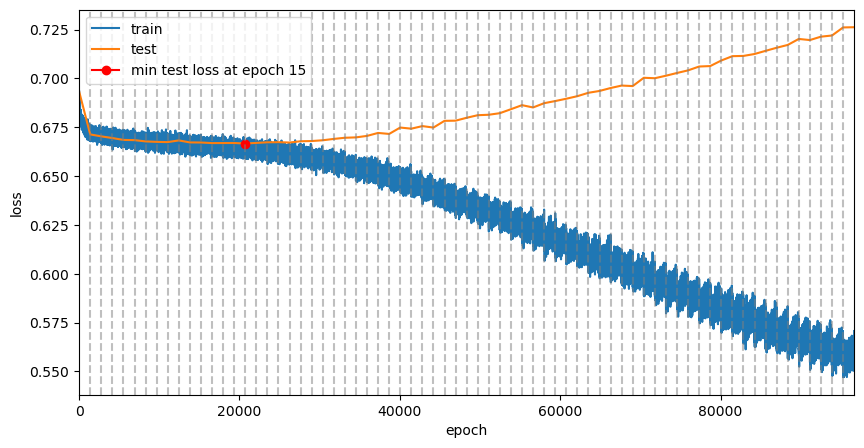

In [4]:
# load training history
train_history = np.loadtxt("./experimental_model/experimental_model_train_history.txt")
test_history = np.loadtxt("./experimental_model/experimental_model_test_history.txt")

# add first training loss to test history
test_history = np.insert(test_history, 0, train_history[0])

# plot training history
# set fig size
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_history)), train_history)
# calculate number of batches per epoch
num_batches_per_epoch = 1381
# plot test loss per epoch
plt.plot(range(0, len(test_history)*num_batches_per_epoch, num_batches_per_epoch), test_history)
#plot minimum test loss
plt.plot(np.argmin(test_history)*num_batches_per_epoch, np.min(test_history), marker="o", color="red")
# plot vertical lines to indicate epochs
for i in range(1, epochs):
    plt.axvline(x=i*num_batches_per_epoch, color="grey", linestyle="--", alpha=0.5)
# limit x axis to epochs so far
plt.xlim(0, 70*num_batches_per_epoch)
# plt.ylim(0.66, 0.68)
plt.legend(["train", "test", f"min test loss at epoch {np.argmin(test_history)}"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [5]:
# load prediction history
prediction_history = np.loadtxt("./experimental_model/experimental_model_prediction_history.txt")
print(prediction_history.shape)
prediction_history[0]

(70, 2148)


array([0.50963259, 0.54539728, 0.45815814, ..., 0.49433744, 0.49427313,
       0.49368382])

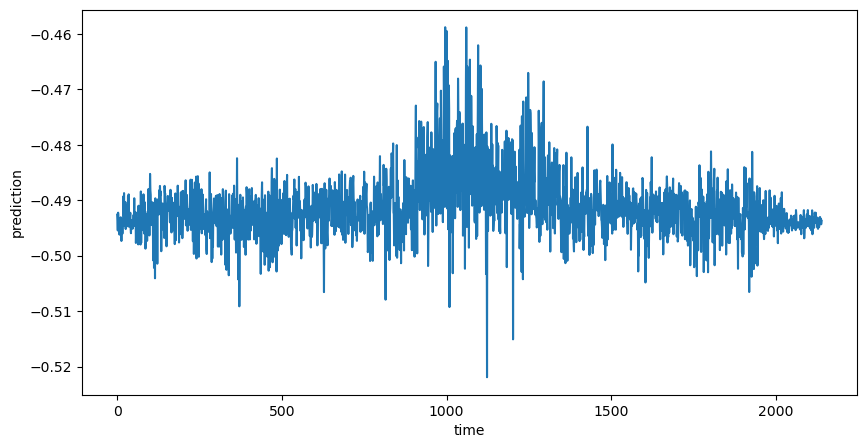

In [6]:
# line plot of last row of prediction history
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[0][8:])), -1*prediction_history[0][8:])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

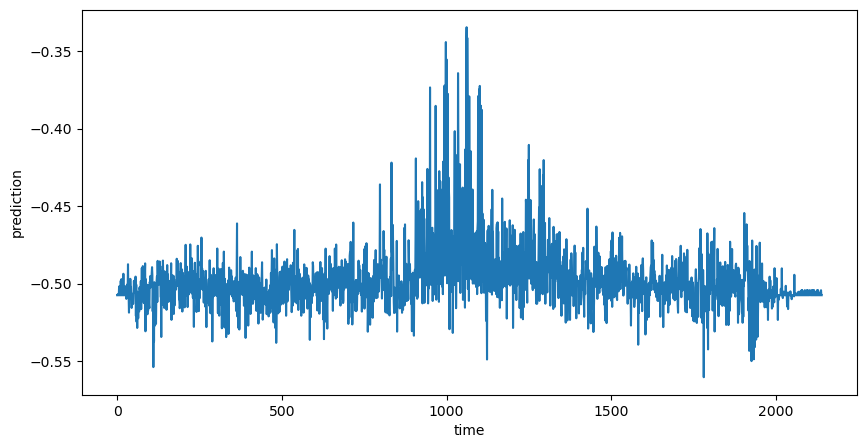

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[14][8:])), -1*prediction_history[14][8:])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

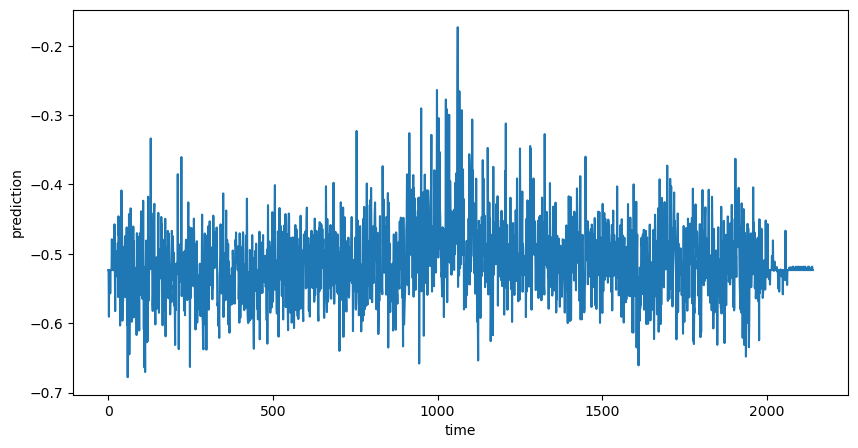

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[-1][8:])), -1*prediction_history[-1][8:])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

In [8]:
#load history
with open('./experimental_model/experimental_model_history.json', 'r') as f:
    history = json.load(f)

In [7]:
#load final model
input_size = len(open(training_path).readline().split('_')[0])
model = MIMENetEnsemble.MIMENetEnsemble(input_size=input_size, hidden_size_factor=hidden_size_factor, bottleneck=bottleneck, output_size=1)
#load model from epoch 15
model.load_state_dict(torch.load('./experimental_model/experimental_model_epoch_15.pt'))
model.to('cuda')

MIMENetEnsemble(
  (fc1): Linear(in_features=2148, out_features=4296, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=4296, out_features=2148, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=2148, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Text(0, 0.5, 'Avg Difference')

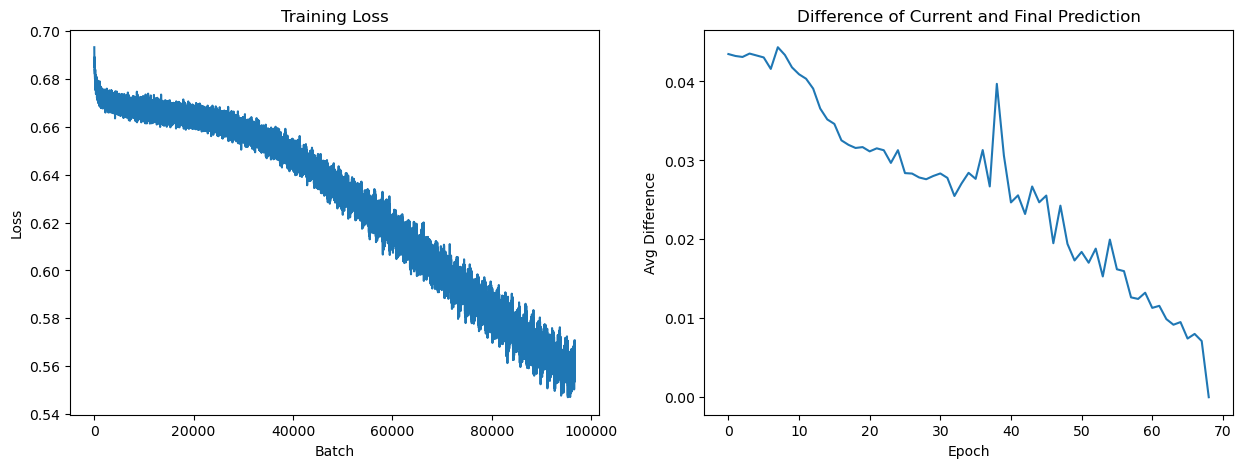

In [10]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

In [8]:
path_wildtype = "../data/experimental_data/5NL43.txt"

In [12]:
with open(path_wildtype, 'r') as f:
        wildtype = f.read()
        
print(wildtype)

GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTAACTAGGGAACCCACTGCTTAAGCCTCAATAAAGCTTGCCTTGAGTGCTCAAAGTAGTGTGTGCCCGTCTGTTGTGTGACTCTGGTAACTAGAGATCCCTCAGACCCTTTTAGTCAGTGTGGAAAATCTCTAGCAGTGGCGCCCGAACAGGGACTTGAAAGCGAAAGTAAAGCCAGAGGAGATCTCTCGACGCAGGACTCGGCTTGCTGAAGCGCGCACGGCAAGAGGCGAGGGGCGGCGACTGGTGAGTACGCCAAAAATTTTGACTAGCGGAGGCTAGAAGGAGAGAGATGGGTGCGAGAGCGTCGGTATTAAGCGGGGGAGAATTAGATAAATGGGAAAAAATTCGGTTAAGGCCAGGGGGAAAGAAACAATATAAACTAAAACATATAGTATGGGCAAGCAGGGAGCTAGAACGATTCGCAGTTAATCCTGGCCTTTTAGAGACATCAGAAGGCTGTAGACAAATACTGGGACAGCTACAACCATC


In [9]:
kds_nucleotide, kds_position = MIMENetEnsemble.inferSingleKds(model, 4, 2, path_wildtype, 1000, batch_size)

Device: cuda:0


100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s]


Device: cuda:0


100%|██████████| 1000/1000 [00:28<00:00, 35.37it/s]


In [34]:
kds_nucleotide = np.array(kds_nucleotide)
kds_position = np.array(kds_position)

print(kds_nucleotide.shape)
print(kds_position.shape)

(1605, 10000)
(535, 10000)


In [35]:
kd_values_nuc, kd_values_pos = MIMENetEnsemble.getSingleKds(model, 4, 2, path_wildtype, batch_size)

In [36]:
kd_values_nuc = np.array(kd_values_nuc)
kd_values_pos = np.array(kd_values_pos)

print(kd_values_nuc.shape)
print(kd_values_pos.shape)

(1605,)
(535,)


In [10]:
# save single kd predictions
np.savetxt('./experimental_model/kds_nucleotide.txt', kds_nucleotide)
np.savetxt('./experimental_model/kds_position.txt', kds_position)

In [11]:
# load single kd predictions
kds_nucleotide = np.loadtxt('./experimental_model/kds_nucleotide.txt')
kds_position = np.loadtxt('./experimental_model/kds_position.txt')

In [12]:
kds_nucleotide_means = np.mean(kds_nucleotide, axis=1)
kds_nucleotide_confidence = np.zeros((kds_nucleotide.shape[0], 2))
for i in range(kds_nucleotide.shape[0]):
    kds_nucleotide_confidence[i] = np.quantile(kds_nucleotide[i], [0.025, 0.975])
kds_nucleotide_p_values = np.zeros(kds_nucleotide.shape[0])
for i in range(kds_nucleotide.shape[0]):
    kds_nucleotide_p_values[i] = np.sum(kds_nucleotide[i] < 1)/kds_nucleotide.shape[1]

kds_position_means = np.mean(kds_position, axis=1)
kds_position_confidence = np.zeros((kds_position.shape[0], 2))
for i in range(kds_position.shape[0]):
    kds_position_confidence[i] = np.quantile(kds_position[i], [0.025, 0.975])
kds_position_p_values = np.zeros(kds_position.shape[0])
for i in range(kds_position.shape[0]):
    kds_position_p_values[i] = np.sum(kds_position[i] < 1)/kds_position.shape[1]

print(kds_nucleotide_means.shape)
print(kds_nucleotide_confidence.shape)
print(kds_nucleotide_p_values.shape)
print(kds_nucleotide_p_values[:10])
print(np.sum(kds_nucleotide_p_values < 0.05))
print(kds_position_means.shape)
print(kds_position_confidence.shape)
print(kds_position_p_values.shape)
print(kds_position_p_values[:10])
print(np.sum(kds_position_p_values < 0.05))

(1605,)
(1605, 2)
(1605,)
[0.503 0.518 0.495 0.714 0.707 0.686 0.869 0.87  0.869 0.842]
379
(535,)
(535, 2)
(535,)
[0.27  0.494 0.734 0.708 0.88  0.302 0.268 0.345 0.009 0.198]
234


In [13]:
def benjamini_hochberg(p_values, alpha):
    """This function implements the benjamini-hochberg procedure for controlling the false discovery rate
    and returns the p-value threshold for significance"""
    # sort p-values
    p_values = np.sort(p_values)
    # calculate critical value
    critical_value = np.min(np.where(p_values > np.arange(1, len(p_values)+1)*alpha/len(p_values)))
    # return p-value threshold
    return p_values[critical_value]

In [14]:
kds_nucleotide_threshold = benjamini_hochberg(kds_nucleotide_p_values, 0.05)
kds_position_threshold = benjamini_hochberg(kds_position_p_values, 0.05)
print(kds_nucleotide_threshold)
print(kds_position_threshold)

0.008
0.018


In [15]:
# iterate over all nucleotide kds and check if they are significant
significant_kds = []
for i in range(kds_nucleotide.shape[0]):
    if kds_nucleotide_p_values[i] < kds_nucleotide_threshold:
        significant_kds.append(1)
    else:
        significant_kds.append(0)

print(sum(significant_kds))

250


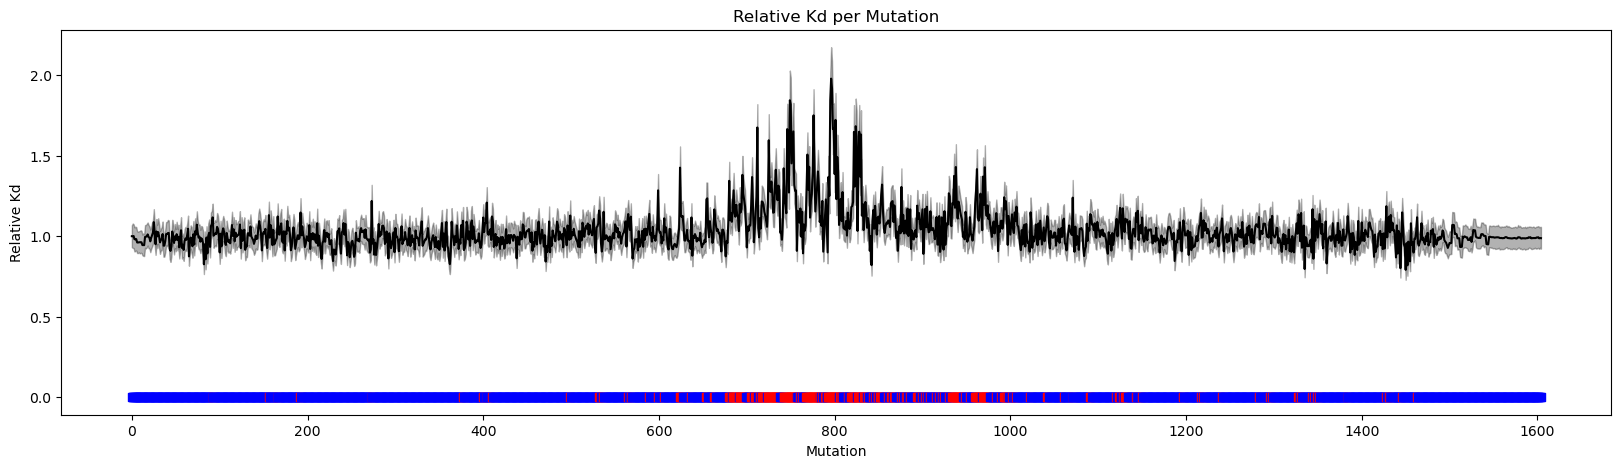

In [16]:
# plot kd per nucleotide along sequence with confidence interval as lower alpha
plt.figure(figsize=(20, 5))
plt.plot(kds_nucleotide_means, color='black')
plt.fill_between(np.arange(kds_nucleotide_means.shape[0]), kds_nucleotide_confidence[:, 0], kds_nucleotide_confidence[:, 1], alpha=0.3, color='black')
plt.scatter(np.arange(kds_nucleotide_means.shape[0]), np.zeros(kds_nucleotide_means.shape[0]), c=significant_kds, cmap='bwr', marker=',')
plt.xlabel('Mutation')
plt.ylabel('Relative Kd')
plt.title('Relative Kd per Mutation')
plt.show()

In [17]:
# line plot of kd_values_nuc
plt.figure(figsize=(20, 5))
plt.plot(kd_values_nuc, color='black')
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

NameError: name 'kd_values_nuc' is not defined

<Figure size 2000x500 with 0 Axes>

In [18]:
# iterate over all position kds and check if they are significant
significant_kds = []
for i in range(kds_position.shape[0]):
    # if at least one nucleotide at this position is significant, the position is significant
    if np.sum(kds_nucleotide_p_values[i*3:(i+1)*3] < kds_nucleotide_threshold) > 0:
        significant_kds.append(1)
    else:
        significant_kds.append(0)
print(sum(significant_kds))

139


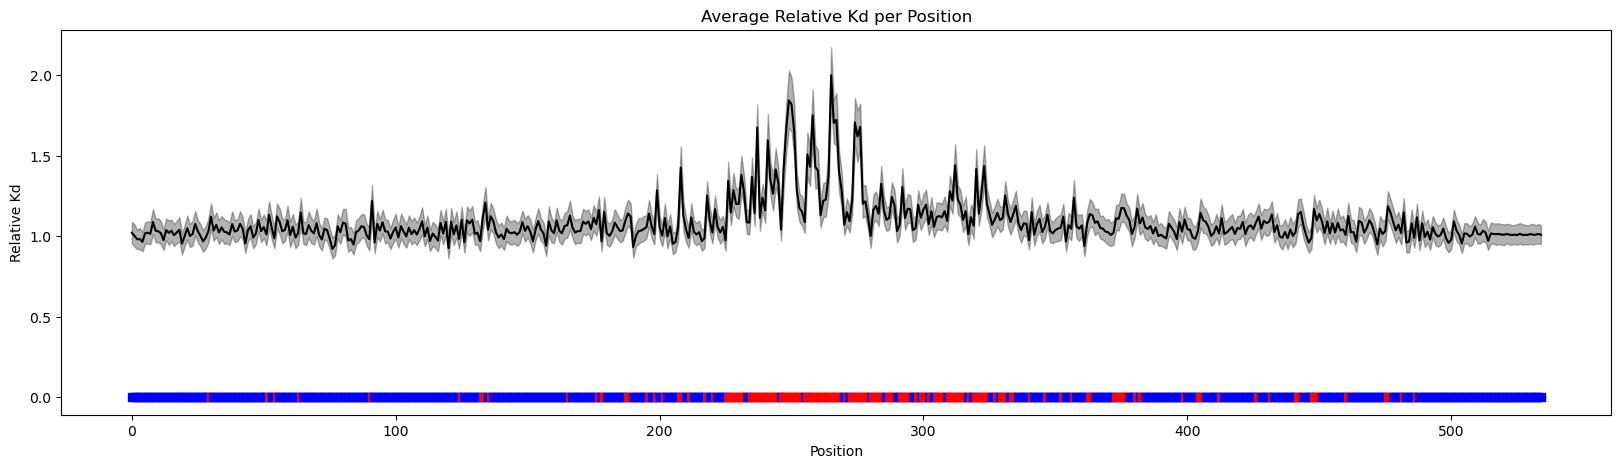

In [19]:
# plot kd per position along sequence with confidence interval as lower alpha
plt.figure(figsize=(20, 5))
plt.plot(kds_position_means, color='black')
plt.fill_between(np.arange(kds_position_means.shape[0]), kds_position_confidence[:, 0], kds_position_confidence[:, 1], alpha=0.3, color='black')
plt.scatter(np.arange(kds_position_means.shape[0]), np.zeros(kds_position_means.shape[0]), c=significant_kds, cmap='bwr', marker=',')
plt.xlabel('Position')
plt.ylabel('Relative Kd')
plt.title('Average Relative Kd per Position')
plt.show()

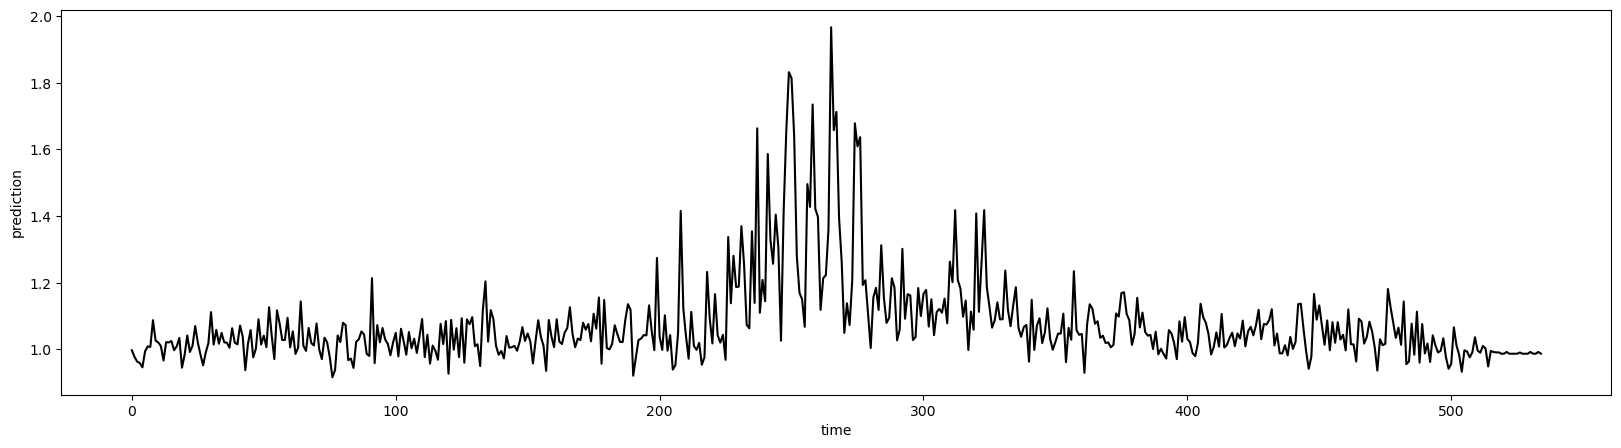

In [47]:
# line plot of kd_values_pos
plt.figure(figsize=(20, 5))
plt.plot(kd_values_pos, color='black')
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

In [6]:
kds_pairwise = MIMENetEnsemble.inferPairwiseKds(model, 4, 2, path_wildtype, 1000, batch_size)

Device: cuda:0


100%|██████████| 1000/1000 [42:32<00:00,  2.55s/it]


Device: cuda:0


100%|██████████| 1000/1000 [6:16:52<00:00, 22.61s/it] 


In [7]:
n = 100

print((n*(n-1)/2)*9)

n = 535

print((n*(n-1)/2)*9)

44550.0
1285605.0


In [8]:
kds_pairwise = np.array(kds_pairwise)
print(kds_pairwise.shape)

(1285605, 1000)


In [9]:
# save pairwise kds
np.savetxt('./experimental_model/pairwise_kds.txt', kds_pairwise)

In [3]:
# load single kd predictions
kds_nucleotide = np.loadtxt('./experimental_model/kds_nucleotide.txt')
print(kds_nucleotide.shape)

(1605, 1000)


In [4]:
kds_pairwise = np.loadtxt('./experimental_model/pairwise_kds.txt')
print(kds_pairwise.shape)

(1285605, 1000)


In [5]:
epistasis, p_values, position_pairs = MIMENetEnsemble.computeEpistasis(kds_nucleotide, kds_pairwise)

In [6]:
print(len(epistasis), len(p_values), len(position_pairs), 535*(535-1)/2)

142845 142845 142845


In [25]:
# save epistasis
np.savetxt('./experimental_model/epistasis.txt', epistasis)
np.savetxt('./experimental_model/p_values.txt', p_values)
np.savetxt('./experimental_model/position_pairs.txt', position_pairs)

In [3]:
# load epistasis
epistasis = np.loadtxt('./experimental_model/epistasis.txt')
p_values = np.loadtxt('./experimental_model/p_values.txt')
position_pairs = np.loadtxt('./experimental_model/position_pairs.txt', dtype=int)

/tmp/ipykernel_272/576579487.py:4: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  position_pairs = np.loadtxt('./experimental_model/position_pairs.txt', dtype=int)


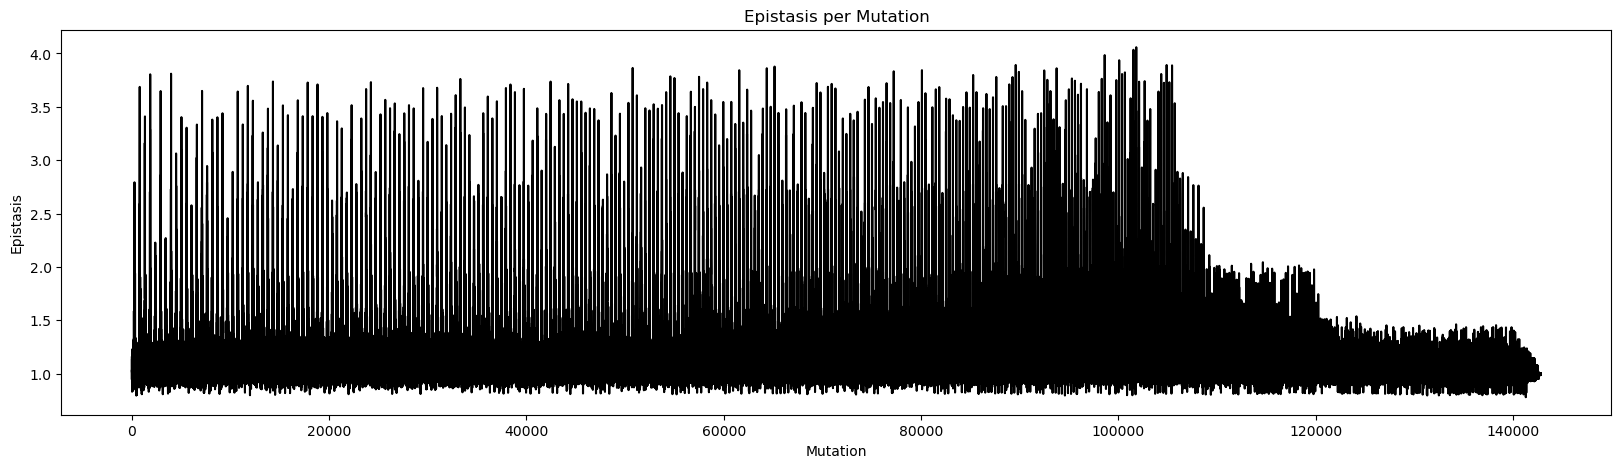

In [4]:
# lineplot of epistasis
plt.figure(figsize=(20, 5))
plt.plot(epistasis, color='black')
plt.xlabel('Mutation')
plt.ylabel('Epistasis')
plt.title('Epistasis per Mutation')
plt.show()

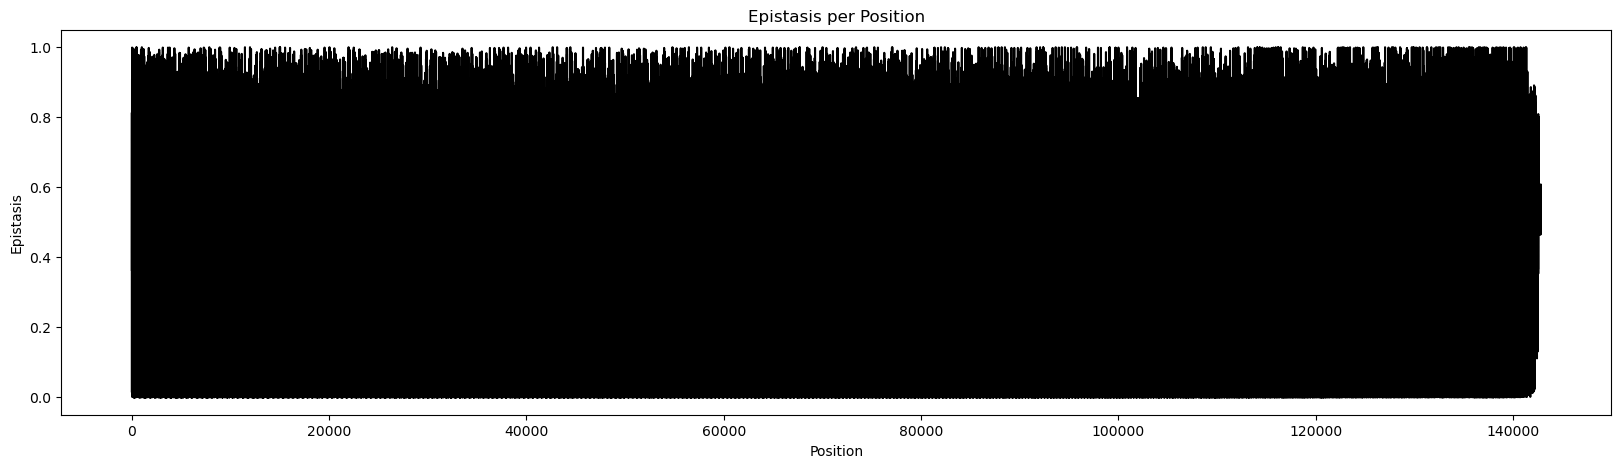

In [5]:
# plot epistasis positions
plt.figure(figsize=(20, 5))
plt.plot(p_values, color='black')
plt.xlabel('Position')
plt.ylabel('Epistasis')
plt.title('Epistasis per Position')
plt.show()

In [51]:
def benjamini_hochberg(p_values, alpha):
    """This function implements the benjamini-hochberg procedure for controlling the false discovery rate
    and returns the p-value threshold for significance"""
    # sort p-values
    p_values = np.sort(p_values)
    # calculate critical value
    critical_value = np.min(np.where(p_values > np.arange(1, len(p_values)+1)*alpha/len(p_values)))
    # return p-value threshold
    return p_values[critical_value]

In [7]:
epistasis_threshold = benjamini_hochberg(p_values, 0.05)
print(epistasis_threshold)

0.008


In [38]:
# iterate over all nucleotide kds and check if they are significant
significant_epistasis = []
for i in range(len(epistasis)):
    if p_values[i] < epistasis_threshold:
        significant_epistasis.append(1)
    else:
        significant_epistasis.append(0)

print(sum(significant_epistasis))

22494


In [8]:
# create 535x535 matrix with epistasis values
epistasis_matrix = np.zeros((535, 535))
for i in range(len(position_pairs)):
    epistasis_matrix[position_pairs[i][0], position_pairs[i][1]] = epistasis[i]
    epistasis_matrix[position_pairs[i][1], position_pairs[i][0]] = epistasis[i]

# save epistasis matrix
np.savetxt('./experimental_model/epistasis_matrix.txt', epistasis_matrix)

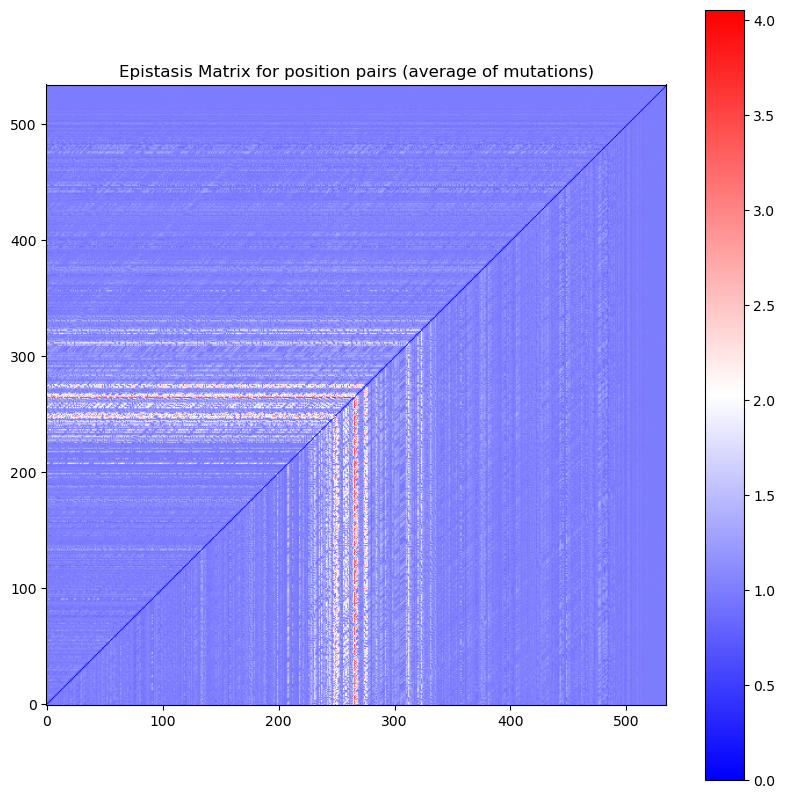

In [2]:
# load epistasis matrix
epistasis_matrix = np.loadtxt('./experimental_model/epistasis_matrix.txt')

# plot epistasis matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix, cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Epistasis Matrix for position pairs (average of mutations)')
plt.show()

In [10]:
# create 535x535 matrix with p-values
p_values_matrix = np.zeros((535, 535))
for i in range(len(position_pairs)):
    p_values_matrix[position_pairs[i][0], position_pairs[i][1]] = p_values[i]
    p_values_matrix[position_pairs[i][1], position_pairs[i][0]] = p_values[i]

# save p-values matrix
np.savetxt('./experimental_model/p_values_matrix.txt', p_values_matrix)

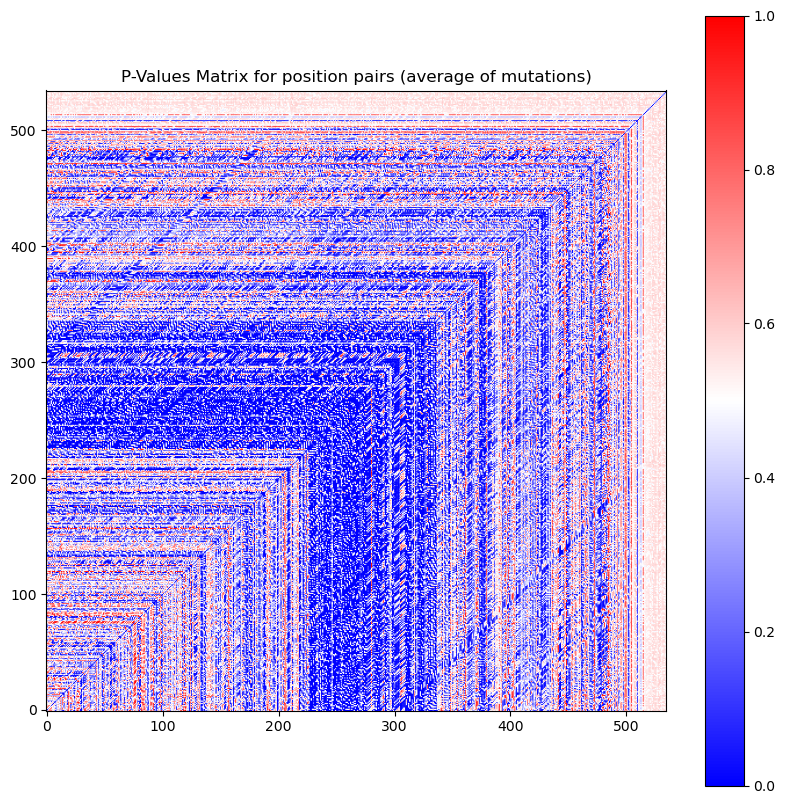

In [190]:
# load p-values matrix
p_values_matrix = np.loadtxt('./experimental_model/p_values_matrix.txt')

# plot p-values matrix as heatmap
plt.figure(figsize=(10, 10))
plt.imshow(p_values_matrix, cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('P-Values Matrix for position pairs (average of mutations)')
plt.show()

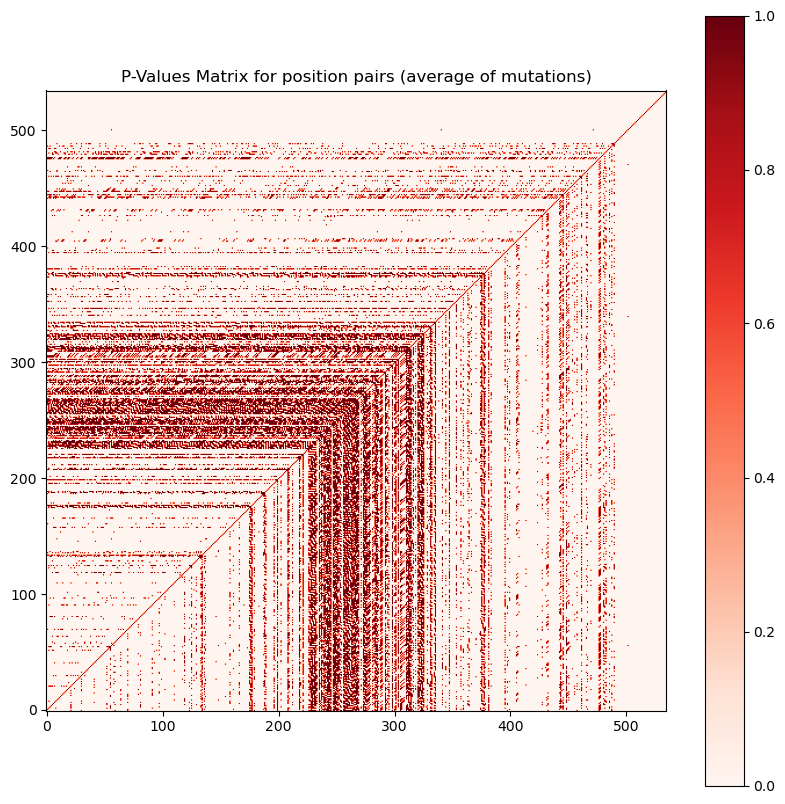

In [19]:
# plot p-values matrix as heatmap with significance
plt.figure(figsize=(10, 10))
plt.imshow(p_values_matrix < 0.008, cmap='Reds')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('P-Values Matrix for position pairs (average of mutations)')
plt.show()

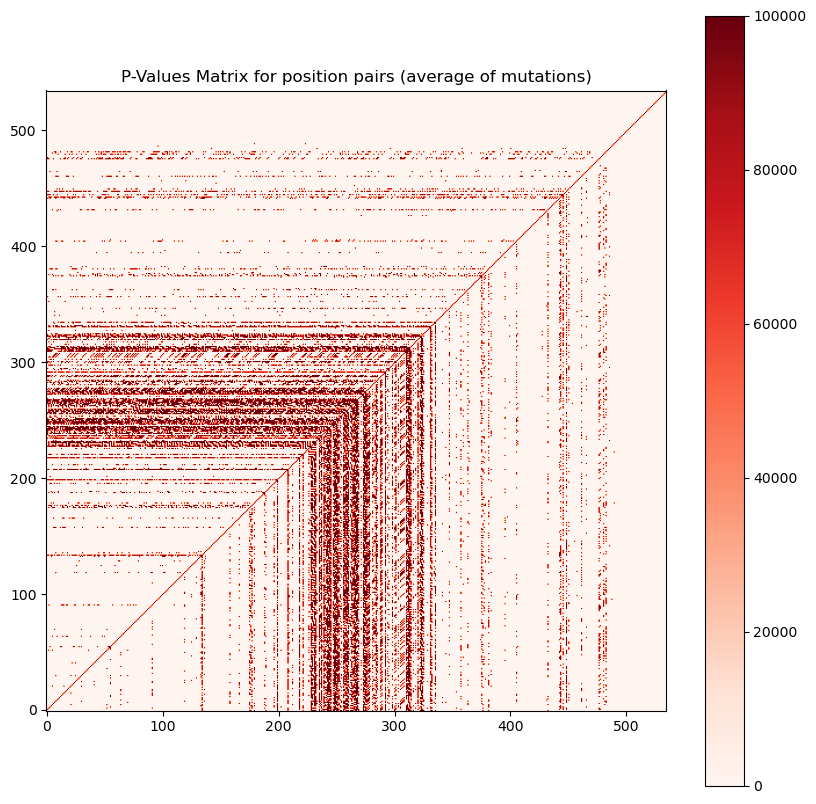

In [20]:
# plot heatmap of p values < benjamini-hochberg threshold
plt.figure(figsize=(10, 10))
epsilon = 0.00001
plt.imshow((1/(p_values_matrix+epsilon) * (p_values_matrix < 0.008)), cmap='Reds')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('P-Values Matrix for position pairs (average of mutations)')
plt.show()

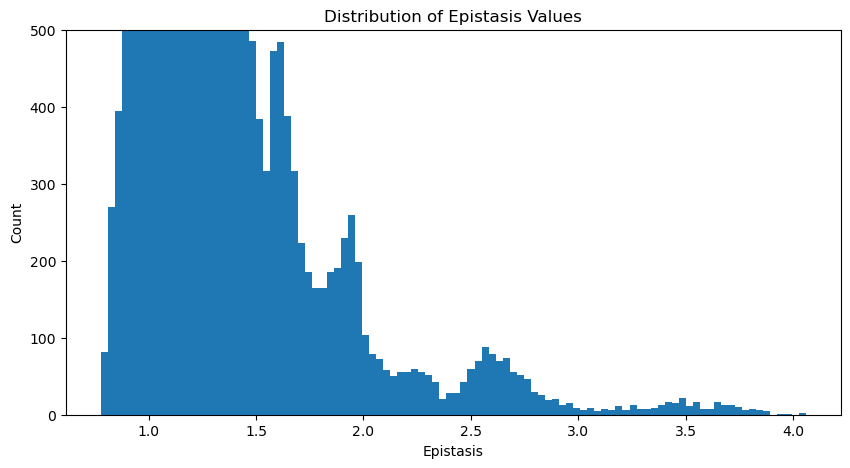

In [42]:
# plot distribution of epistasis values
plt.figure(figsize=(10, 5))
plt.hist(epistasis, bins=100)
plt.xlabel('Epistasis')
plt.ylabel('Count')
# set y axis limit to 0-1000
plt.ylim(0, 500)
plt.title('Distribution of Epistasis Values')
plt.show()

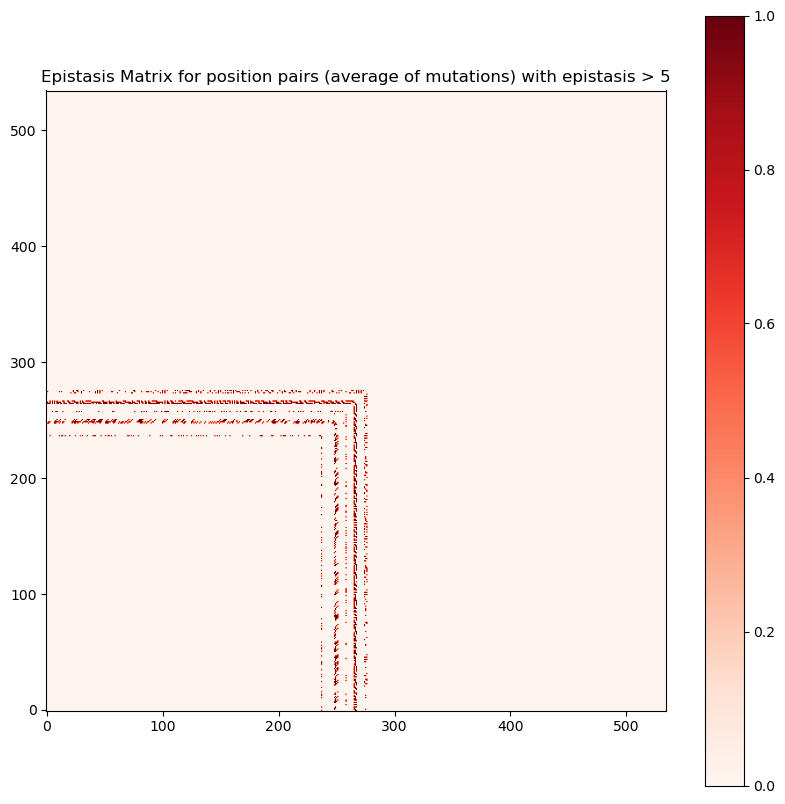

In [43]:
# plot epistasis matrix as heatmap with only epistasis > 5
plt.figure(figsize=(10, 10))
plt.imshow(epistasis_matrix >= 2.4, cmap='Reds')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Epistasis Matrix for position pairs (average of mutations) with epistasis > 5')
plt.show()

In [53]:
# load single kd predictions
kds_position = np.loadtxt('./experimental_model/kds_position.txt')
kds_position_p_values = np.zeros(kds_position.shape[0])
for i in range(kds_position.shape[0]):
    kds_position_p_values[i] = np.sum(kds_position[i] < 1)/kds_position.shape[1]
kds_position_threshold = benjamini_hochberg(kds_position_p_values, 0.05)
print(kds_position_threshold)

0.018


In [55]:
# get significant positions
significant_positions = []
for i in range(kds_position.shape[0]):
    if kds_position_p_values[i] < kds_position_threshold:
        significant_positions.append(1)
    else:
        significant_positions.append(0)

print(sum(significant_positions))
print(significant_positions[:10])

191
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


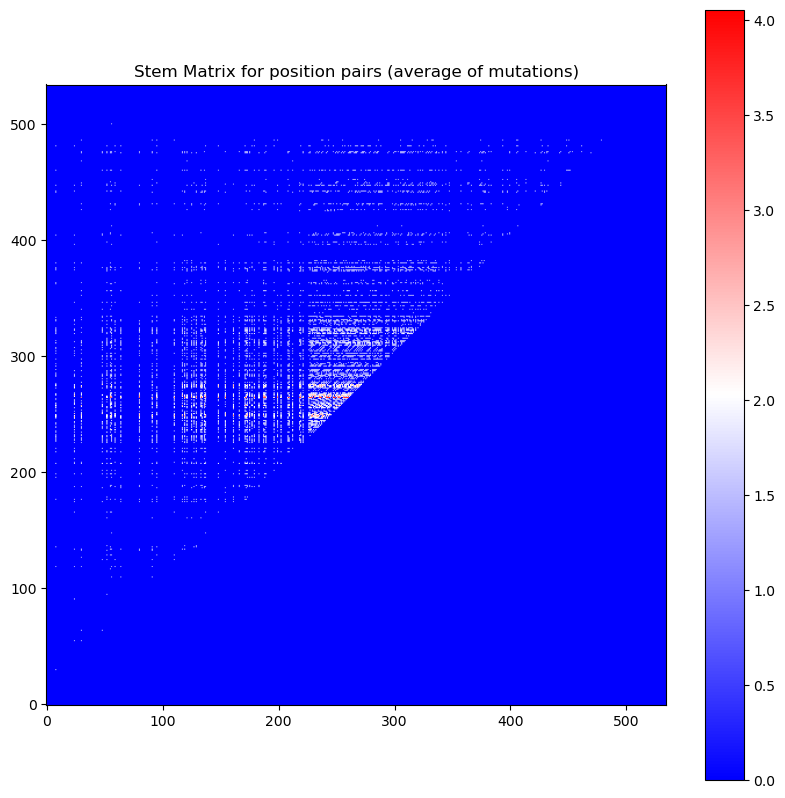

In [214]:
# filter epistasis matrix for significant epistasis values
stem_matrix = epistasis_matrix * (p_values_matrix < 0.008)
# filter epistasis matrix for pairs of significant positions
stem_matrix = stem_matrix * np.outer(significant_positions, significant_positions)
# filter epistasis matrix for pairs of positions where i - j >= 5
for i in range(535):
    for j in range(535):
        if i - j < 5:
            stem_matrix[i, j] = 0
# plot stem matrix
plt.figure(figsize=(10, 10))
plt.imshow(stem_matrix, cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Stem Matrix for position pairs (average of mutations)')
plt.show()


In [ ]:
# plot stem matrix
plt.figure(figsize=(10, 10))
plt.imshow(stem_matrix[200:350, 200:350], cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
# fix x and y axis ticks
plt.xticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.yticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.colorbar()
plt.title('Stem Matrix for position pairs (average of mutations)')
plt.show()

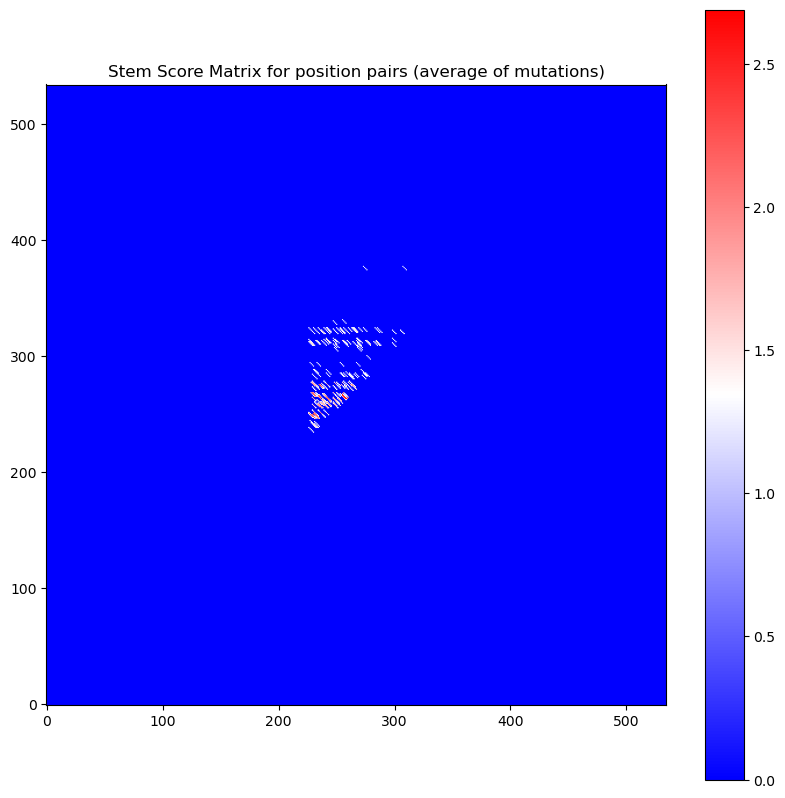

In [212]:
stem_score_matrix = np.zeros((535, 535))

# iterate through antidiagonals of stem matrix
for i in range(-535, 535):
    # get antidiagonal
    antidiagonal = np.diagonal(np.flipud(stem_matrix), offset=i)
    # iterate through antidiagonal
    stems = []
    stemscore = 0
    stemlength = 0
    for j in range(len(antidiagonal)):
        # if epistasis is > 1, add 1 to stemscore
        if antidiagonal[j] > 1:
            stemlength += 1
            stemscore += antidiagonal[j]
        # if epistasis is < 1 set stemscore to 0 again
        if antidiagonal[j] < 1:
            if stemlength >= 4:
                # append anchorpoints of stem to stems
                stems.append((j-stemlength, j, stemscore/stemlength))
            stemlength = 0
            stemscore = 0
    # print(i, stems)   
    stem_diagonal = np.zeros(len(antidiagonal))
    for stem in stems:
        stem_diagonal[stem[0]:stem[1]] = stem[2]
    stem_score_matrix += np.diag(stem_diagonal, k=i)

# plot stem score matrix
plt.figure(figsize=(10, 10))
plt.imshow(np.flipud(stem_score_matrix), cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Stem Score Matrix for position pairs (average of mutations)')
plt.show()
    

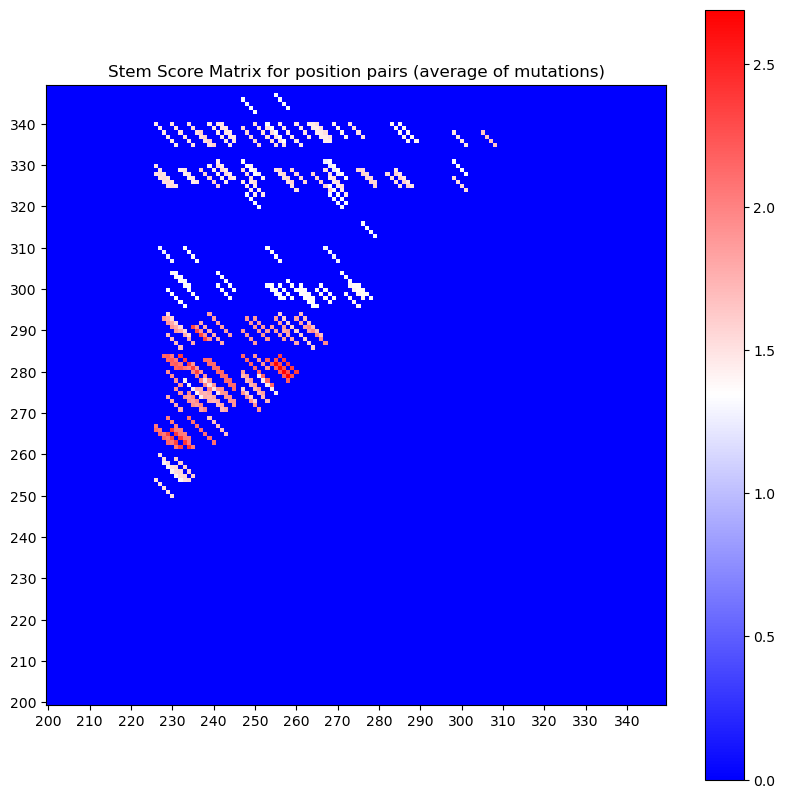

In [213]:
# plot stem score matrix
plt.figure(figsize=(10, 10))
plt.imshow(np.flipud(stem_score_matrix[200:350,200:350]), cmap='bwr')
# invert y axis to match sequence
plt.gca().invert_yaxis()
# fix ticks to match sequence
plt.xticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.yticks(np.arange(0, 150, 10), np.arange(200, 350, 10))
plt.colorbar()
plt.title('Stem Score Matrix for position pairs (average of mutations)')
plt.show()